# Цель работы: 
### Выяснить является ли данная выборка экпертов валидной для метода экспертных оценок


# План работы: 
1. Первичная обрaботка данных
2. Исследовательский анализ данных
3. Рассмотрение корреляции признаков 
4. Кластеризация и ее последующий анализ
5. Вывод 

## Выдвинем гипотезы для последующей проверки
- гипотеза 1: дисперсия характеристик исходной группы должна быть примерно равна дисперсии каждрой из подгрупп (одинаковые люди - одинаковые оценки)
чем больше дисперсия, тем больше согласованность
- гипотеза 2: существует прямая корреляция между образованием и уровнем должности
- гипотеза 3: чем выше должность, тем больше доля мужчин

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, OPTICS
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings("ignore")

 ## Первичная обработка данных

In [164]:
path = "данные для обработки.xlsx"
try:
    df = pd.read_excel(path)
except:
    raise FileNotFoundError('Файл не найден')

In [165]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

In [166]:
data_preview(df)

,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
14,1,3,4,12,29,94,78,41,78,40,71,84,30,23,73
475,2,3,1,60,27,7,81,37,21,48,72,0,93,64,36
176,2,3,3,66,68,94,77,40,22,31,5,32,34,87,4
67,1,3,5,60,36,31,96,19,13,82,91,55,17,2,37
183,1,3,2,77,93,57,64,80,28,28,17,0,100,59,4


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Пол                1034 non-null   object
 1   Образование        1034 non-null   object
 2   Уровень должности  1034 non-null   int64 
 3   Настороженность    1034 non-null   int64 
 4   Расчётливость      1034 non-null   int64 
 5   Жёсткость          1034 non-null   int64 
 6   Независимость      1034 non-null   int64 
 7   Авантюризм         1034 non-null   int64 
 8   Непрактичность     1034 non-null   int64 
 9   Осторожность       1034 non-null   int64 
 10  Нормативность      1034 non-null   int64 
 11  Жертвенность       1034 non-null   int64 
 12  Эмоциональность    1034 non-null   int64 
 13  Расслабленность    1034 non-null   int64 
 14  Безынициативность  1034 non-null   

Пол                  0.0
Образование          0.0
Уровень должности    0.0
Настороженность      0.0
Расчётливость        0.0
Жёсткость            0.0
Независимость        0.0
Авантюризм           0.0
Непрактичность       0.0
Осторожность         0.0
Нормативность        0.0
Жертвенность         0.0
Эмоциональность      0.0
Расслабленность      0.0
Безынициативность    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,3.344294,66.211799,48.596712,50.358801,58.043520,46.680851,46.900387,58.361702,62.679884,44.210832,38.969052,32.755319,43.552224
std,1.665501,27.592643,29.732184,31.919427,30.309265,30.143745,28.629839,24.422403,28.372454,33.106944,27.561337,27.171377,29.016397
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,47.000000,24.000000,20.000000,32.000000,17.000000,21.000000,40.000000,39.000000,12.000000,20.000000,10.000000,21.000000
50%,3.000000,73.000000,50.000000,53.000000,54.000000,43.000000,47.000000,59.000000,70.000000,44.000000,34.000000,28.000000,33.000000
75%,4.000000,88.000000,74.000000,81.000000,89.000000,71.000000,69.000000,80.000000,89.000000,78.000000,63.000000,50.000000,70.000000
max,8.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [167]:
df['Пол'].value_counts()

Пол
1       691
2       342
1, 1      1
Name: count, dtype: int64

In [168]:
df.loc[df['Пол'] == '1, 1', 'Пол'] = 1
df['Пол'] = pd.to_numeric(df['Пол'], errors='coerce')
df['Пол'].value_counts()

Пол
1    692
2    342
Name: count, dtype: int64

In [169]:
df['Образование'].value_counts()

Образование
3       731
4       214
2        76
1        12
3, 3      1
Name: count, dtype: int64

In [170]:
df.loc[df['Образование'] == '3, 3', 'Образование'] = 3
df['Образование'] = pd.to_numeric(df['Образование'], errors='coerce')
df['Образование'].value_counts()

Образование
3    732
4    214
2     76
1     12
Name: count, dtype: int64

In [171]:
data_preview(df)

,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
36,2,4,4,0,4,29,77,37,47,89,64,9,80,39,21
828,1,3,4,94,36,81,23,1,49,85,97,83,18,74,23
739,1,3,3,19,4,38,99,54,28,97,91,94,2,2,21
882,1,3,5,62,91,70,23,64,21,48,96,4,66,2,96
367,1,3,8,94,89,32,31,78,98,35,10,86,17,18,78


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                1034 non-null   int64
 1   Образование        1034 non-null   int64
 2   Уровень должности  1034 non-null   int64
 3   Настороженность    1034 non-null   int64
 4   Расчётливость      1034 non-null   int64
 5   Жёсткость          1034 non-null   int64
 6   Независимость      1034 non-null   int64
 7   Авантюризм         1034 non-null   int64
 8   Непрактичность     1034 non-null   int64
 9   Осторожность       1034 non-null   int64
 10  Нормативность      1034 non-null   int64
 11  Жертвенность       1034 non-null   int64
 12  Эмоциональность    1034 non-null   int64
 13  Расслабленность    1034 non-null   int64
 14  Безынициативность  1034 non-null   int64
dtypes: in

Пол                  0.0
Образование          0.0
Уровень должности    0.0
Настороженность      0.0
Расчётливость        0.0
Жёсткость            0.0
Независимость        0.0
Авантюризм           0.0
Непрактичность       0.0
Осторожность         0.0
Нормативность        0.0
Жертвенность         0.0
Эмоциональность      0.0
Расслабленность      0.0
Безынициативность    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,1.330754,3.110251,3.344294,66.211799,48.596712,50.358801,58.043520,46.680851,46.900387,58.361702,62.679884,44.210832,38.969052,32.755319,43.552224
std,0.470712,0.561280,1.665501,27.592643,29.732184,31.919427,30.309265,30.143745,28.629839,24.422403,28.372454,33.106944,27.561337,27.171377,29.016397
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,47.000000,24.000000,20.000000,32.000000,17.000000,21.000000,40.000000,39.000000,12.000000,20.000000,10.000000,21.000000
50%,1.000000,3.000000,3.000000,73.000000,50.000000,53.000000,54.000000,43.000000,47.000000,59.000000,70.000000,44.000000,34.000000,28.000000,33.000000
75%,2.000000,3.000000,4.000000,88.000000,74.000000,81.000000,89.000000,71.000000,69.000000,80.000000,89.000000,78.000000,63.000000,50.000000,70.000000
max,2.000000,4.000000,8.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## Исследовательский анализ данных

Посмотрим распеределение первых трех признаков

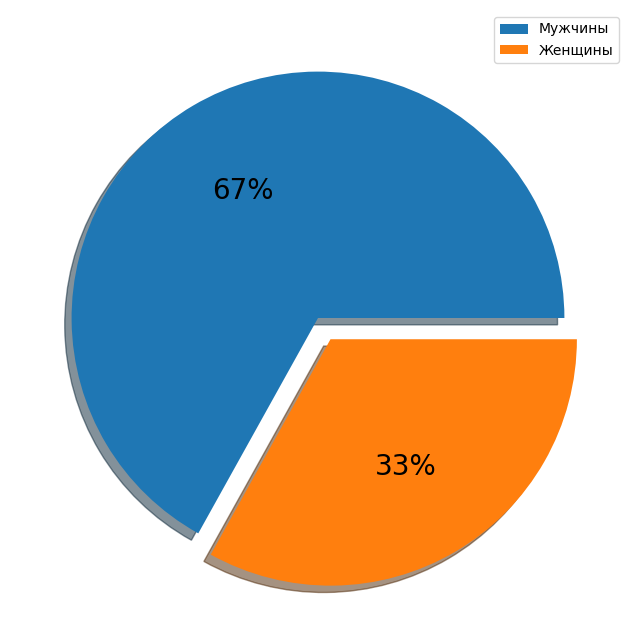

In [172]:
plt.figure(figsize=(8,8))
plt.pie(df['Пол'].value_counts(), explode=[0, 0.1], shadow=True, autopct='%1.0f%%', textprops={'fontsize': 20})
plt.legend(['Мужчины', 'Женщины'])
plt.show()

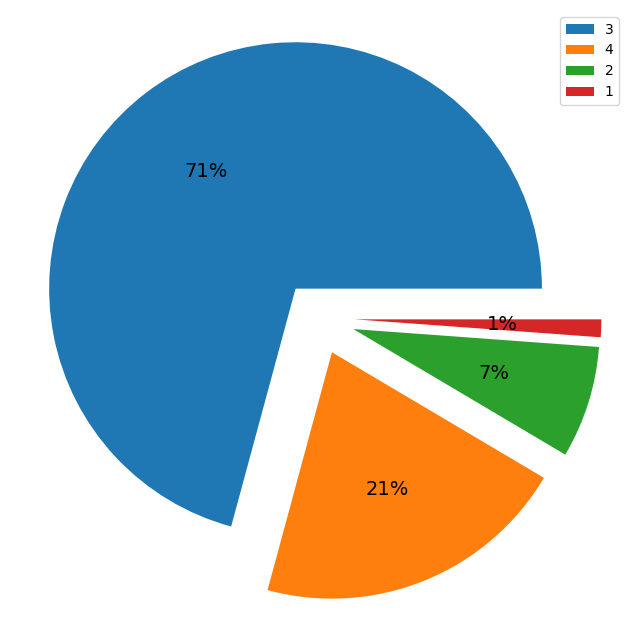

In [173]:
plt.figure(figsize=(8,8))
plt.pie(df['Образование'].value_counts(), explode=[0.15, 0.15, 0.15, 0.15], autopct='%1.0f%%', textprops={'fontsize': 14})
plt.legend(df['Образование'].value_counts().index)
plt.show()

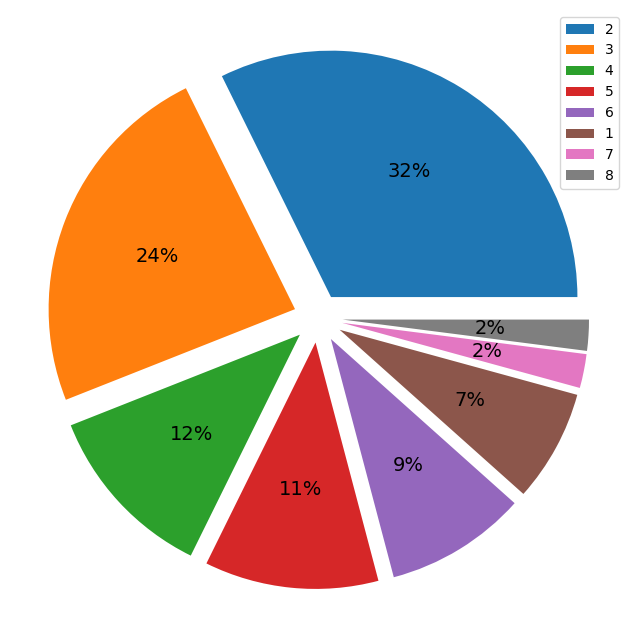

In [174]:
plt.figure(figsize=(8,8))
plt.pie(df['Уровень должности'].value_counts(), explode=[0.1]*8, autopct='%1.0f%%', textprops={'fontsize': 14})
plt.legend(df['Уровень должности'].value_counts().index)
plt.show()

Вывод на основе полученных диаграмм:
- доля мужчин в 2 раза больше, чем доля женщин
- количество людей с образованием 3 в 2 раза больше, чем остальных 
- уровни должности 2 и 3 составляют половину от всей выборки  

Рассмотрим распределение по половому признаку для уровня образования и уровня должности

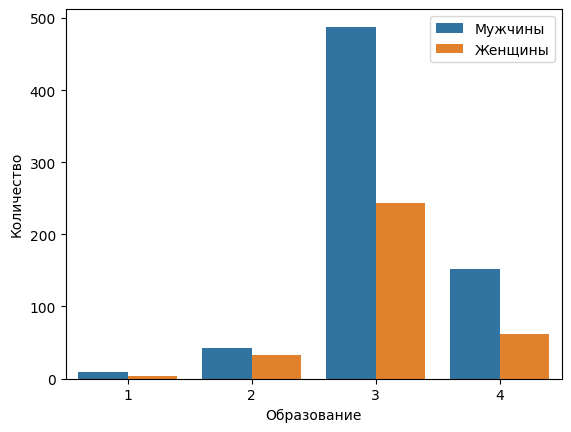

In [175]:
sns.countplot(data=df, x='Образование', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

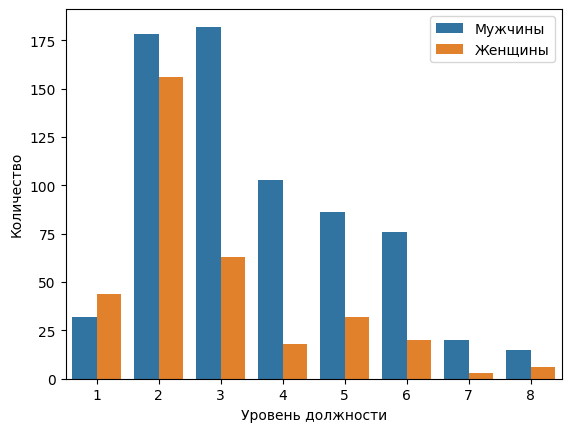

In [176]:
sns.countplot(data=df, x='Уровень должности', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

Вывод на основе столбчатых диаграмм:
- сохраняется отношение между количеством мужчин и женщин вне зависимости от уровня образования
- с увелечинием уровня должности количество мужчин более сильно преобладает над количеством женщин  

## Рассмотрение корреляции признаков

In [194]:
phik_corr = df.phik_matrix()
phik_corr['Уровень должности']

interval columns not set, guessing: ['Пол', 'Образование', 'Уровень должности', 'Настороженность', 'Расчётливость', 'Жёсткость', 'Независимость', 'Авантюризм', 'Непрактичность', 'Осторожность', 'Нормативность', 'Жертвенность', 'Эмоциональность', 'Расслабленность', 'Безынициативность']


Пол                  0.369297
Образование          0.600974
Уровень должности    1.000000
Настороженность      0.065331
Расчётливость        0.056639
Жёсткость            0.026206
Независимость        0.119528
Авантюризм           0.100924
Непрактичность       0.000000
Осторожность         0.133050
Нормативность        0.177509
Жертвенность         0.106917
Эмоциональность      0.100427
Расслабленность      0.000000
Безынициативность    0.000000
Name: Уровень должности, dtype: float64

Образование и Уровень должности коррелириют между собой

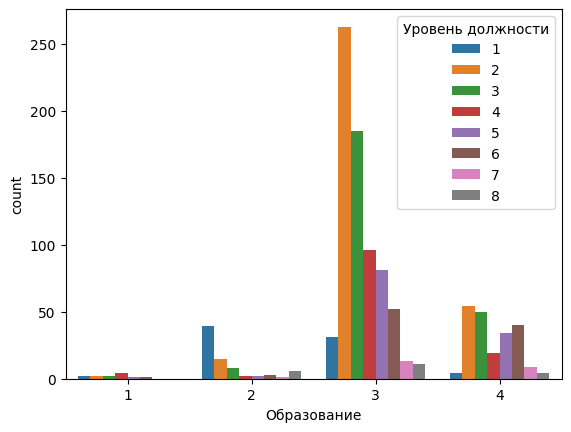

In [192]:
sns.countplot(data=df,  hue='Уровень должности', x='Образование')
plt.show()

## Кластеризация и ее последующий анализ

In [18]:
scaler = StandardScaler()
X = df.iloc[:, 3:]
X = scaler.fit_transform(X)

In [152]:
model = KMeans(n_clusters=10, n_init='auto', max_iter=1000)
gm_4 = model.fit(X)
predict_4 = gm_4.predict(X)

In [153]:
clusters = np.unique(predict_4)
clusterd_df = []
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(predict_4 == cluster)
	clusterd_df.append(df.iloc[list(*row_ix)])

clusterd_df[0].head()

,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
31,1,3,3,57,26,81,36,41,11,73,81,87,34,30,21
33,1,3,6,89,50,60,23,40,13,63,70,78,32,2,44
45,2,3,6,94,43,60,98,6,21,73,91,16,32,28,17
47,1,3,5,87,69,87,96,11,13,100,86,47,2,0,37
76,1,4,6,96,45,55,21,41,83,81,91,45,9,26,21


In [154]:
columns = df.columns[3:]

def find_variance(df, column):
    return np.var(df[column])

In [147]:
for column in columns:
    var = find_variance(df, column)
    print(f'{column} var={var}')

Настороженность var=760.6176170736544
Расчётливость var=883.1478035010794
Жёсткость var=1017.8644921788774
Независимость var=917.7630963114832
Авантюризм var=907.7666159101196
Непрактичность var=818.8749901791693
Осторожность var=595.8769085147536
Нормативность var=804.2176417660285
Жертвенность var=1095.009708592572
Эмоциональность var=758.8926592564603
Расслабленность var=737.5697250915675
Безынициативность var=841.1370211643576


In [148]:
for column in columns:
    var = find_variance(clusterd_df[0], column)
    print(f'{column} var={var}')

Настороженность var=752.8982688547312
Расчётливость var=874.5421014331329
Жёсткость var=1017.4403346451819
Независимость var=923.293676889186
Авантюризм var=904.0934927353284
Непрактичность var=813.3791480408901
Осторожность var=593.0543243979109
Нормативность var=811.2437573327393
Жертвенность var=1085.7504319200018
Эмоциональность var=756.2454830325983
Расслабленность var=738.5018984678597
Безынициативность var=840.7455162000941


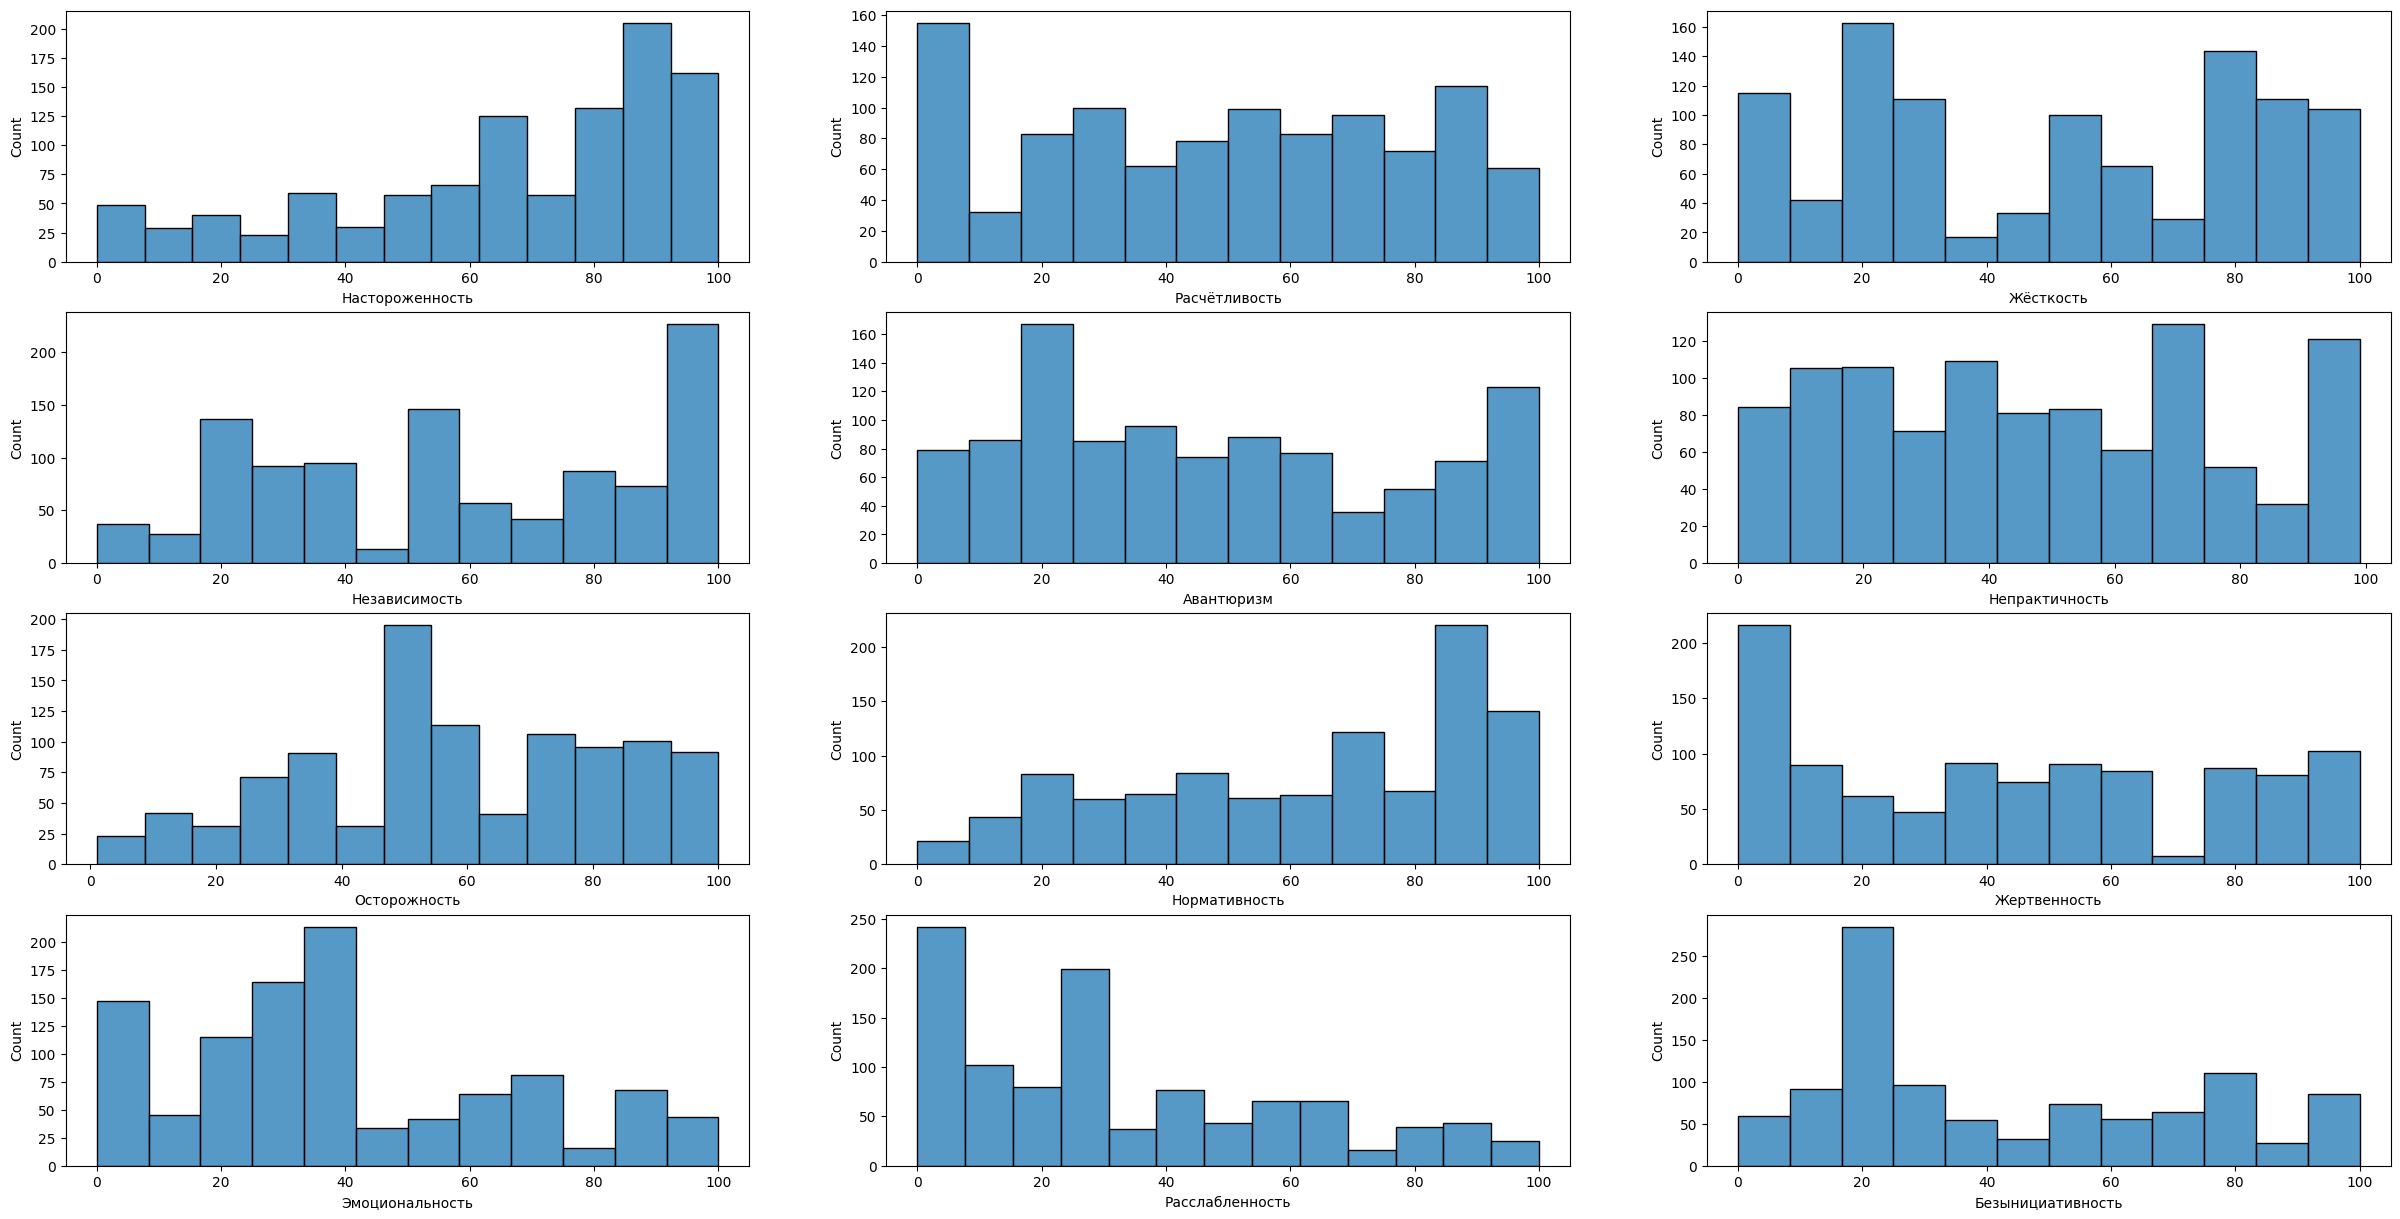

In [149]:
fig, ax = plt.subplots(4, 3, figsize=(30, 15))
h = 0
for i in range(4):
    for j in range(3):
        sns.histplot(ax=ax[i][j], data=df, x=columns[h])
        h += 1

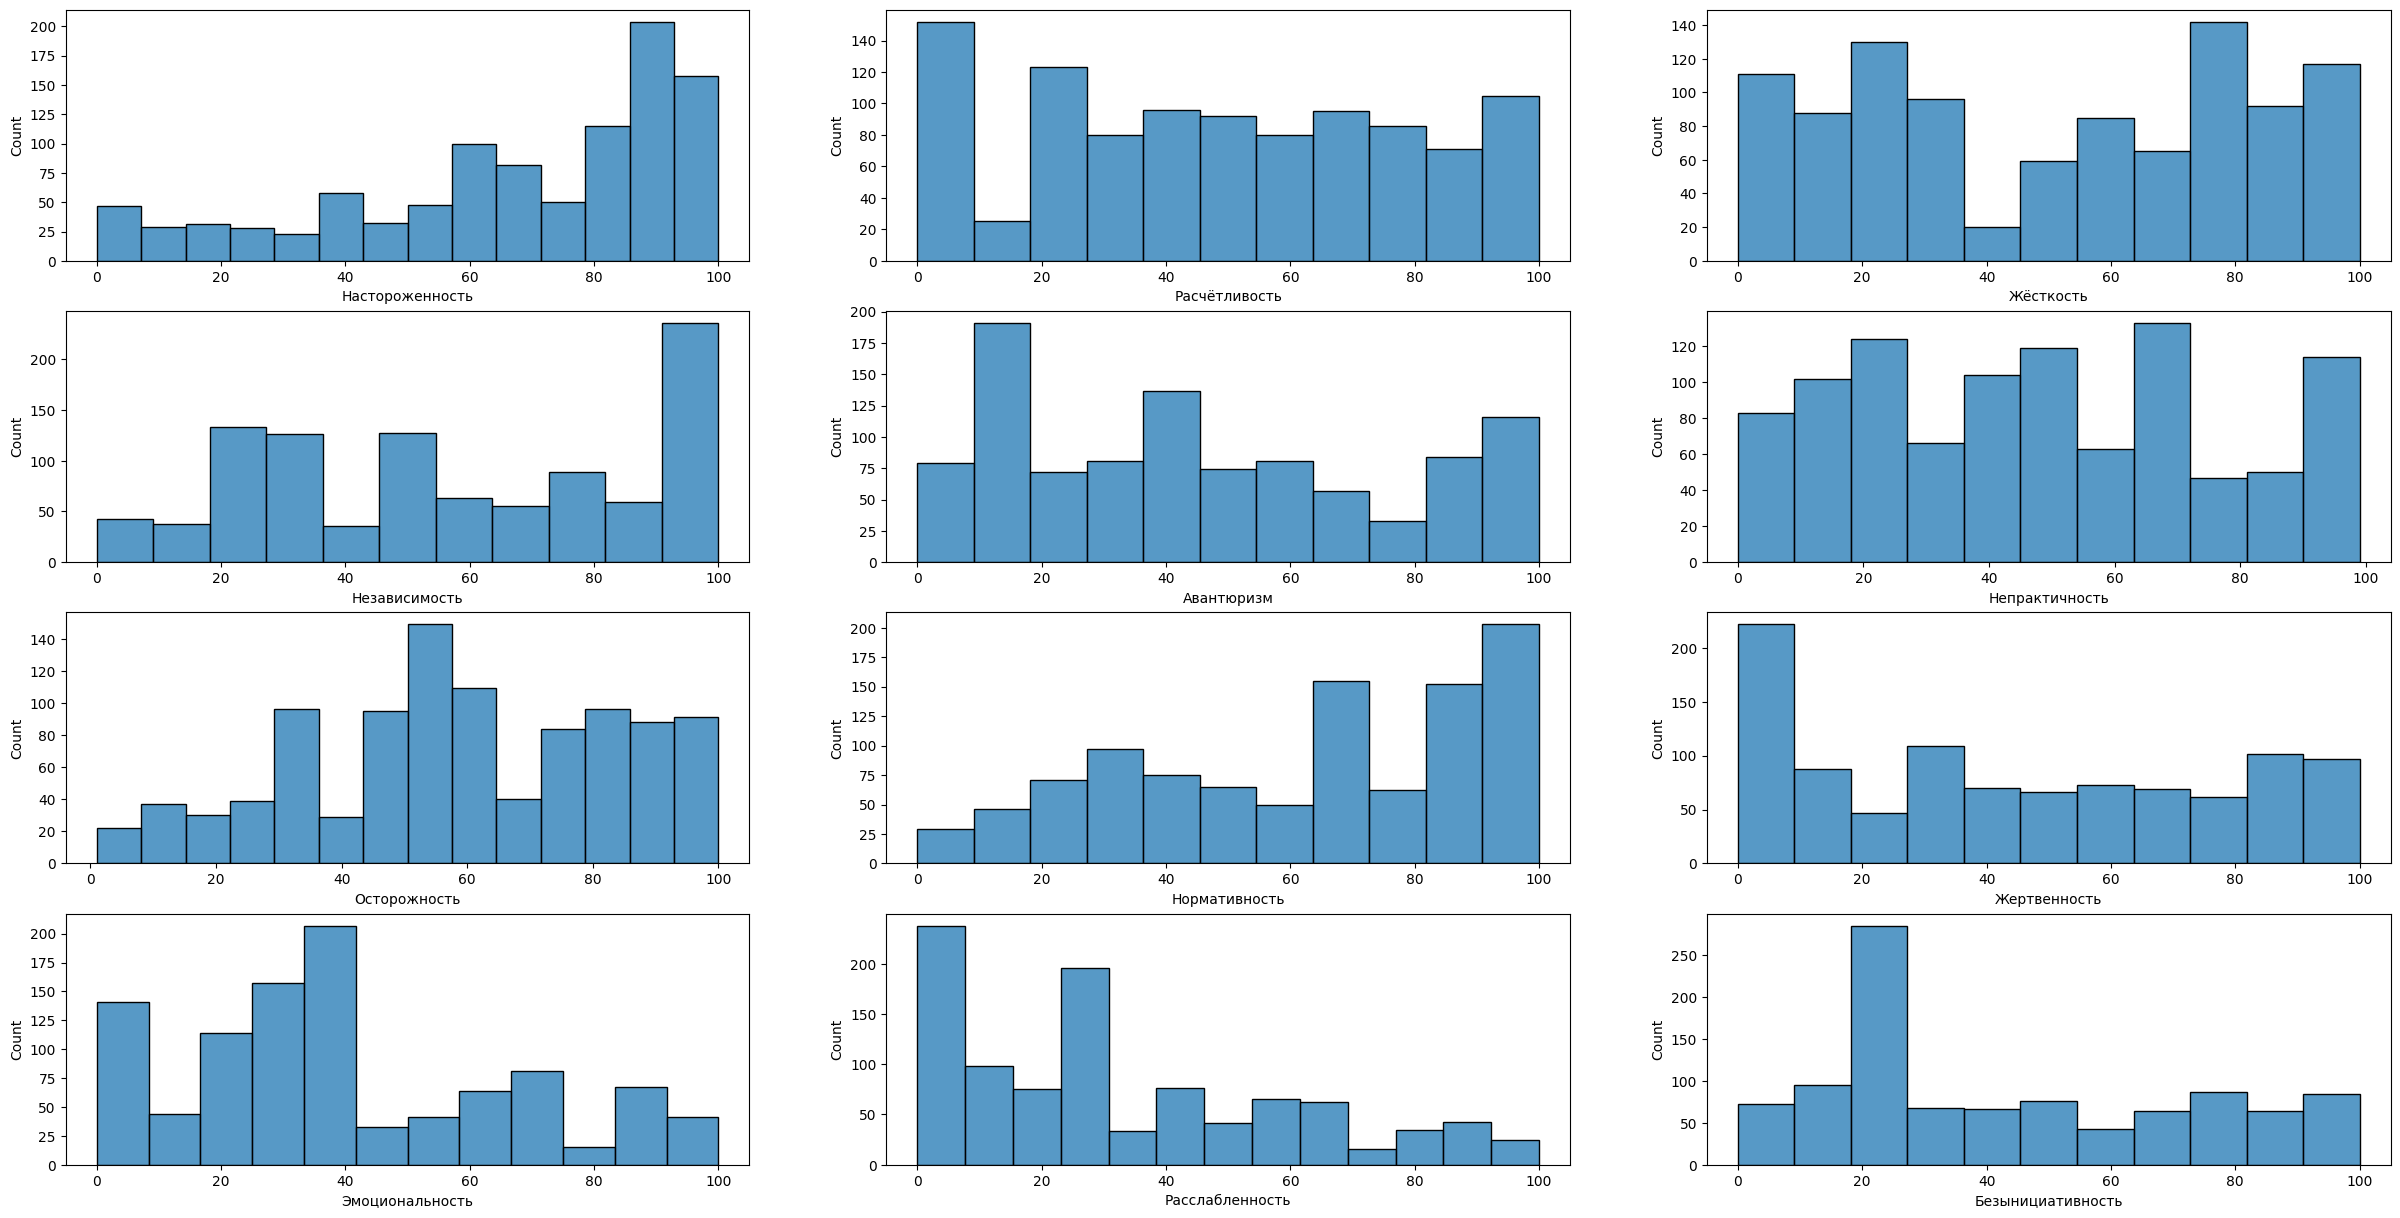

In [150]:
fig, ax = plt.subplots(4, 3, figsize=(30, 15))
h = 0
for i in range(4):
    for j in range(3):
        sns.histplot(ax=ax[i][j], data=clusterd_df[0], x=columns[h])
        h += 1

In [151]:
clusterd_df[0].shape

(1005, 15)

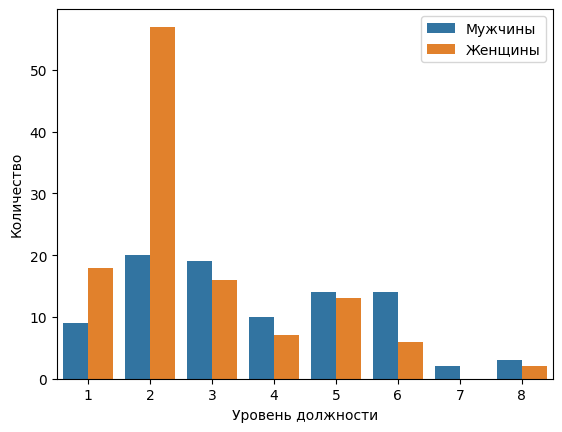

In [98]:
sns.countplot(data=clusterd_df[0], x='Уровень должности', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

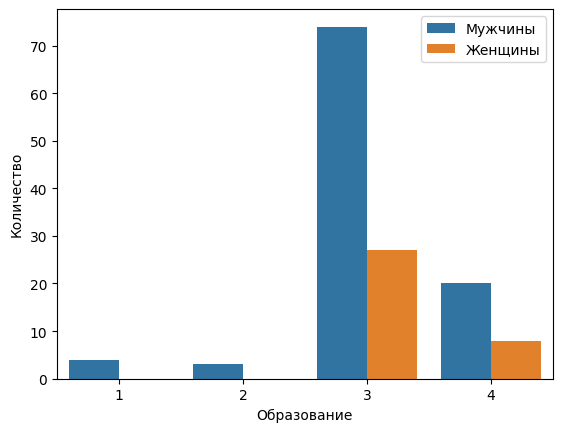

In [77]:
sns.countplot(data=clusterd_df[0], x='Образование', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

In [99]:
clusterd_df[1].shape

(249, 15)

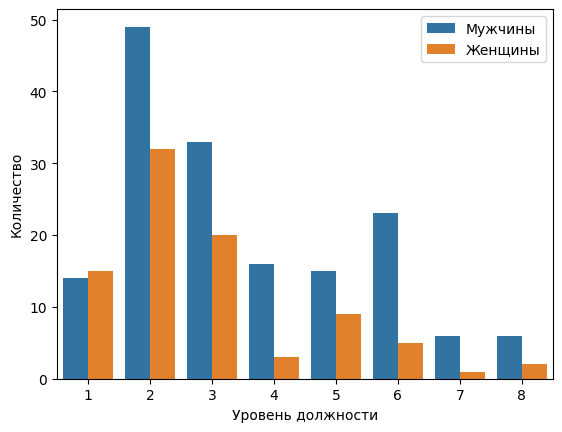

In [100]:
sns.countplot(data=clusterd_df[1], x='Уровень должности', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

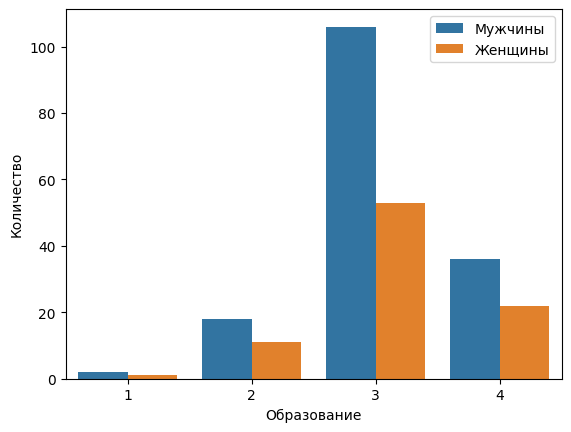

In [101]:
sns.countplot(data=clusterd_df[1], x='Образование', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

In [102]:
for column in columns:
    var = find_variance(clusterd_df[2], column)
    print(f'{column} var={var}')

Настороженность var=265.70520100955474
Расчётливость var=480.0190042665705
Жёсткость var=845.2111051018568
Независимость var=887.3965506880596
Авантюризм var=651.6166846944294
Непрактичность var=471.1877441259539
Осторожность var=474.9245387897362
Нормативность var=522.3956492999218
Жертвенность var=553.9319752418726
Эмоциональность var=518.0167057268193
Расслабленность var=499.264046631813
Безынициативность var=714.7471906736375


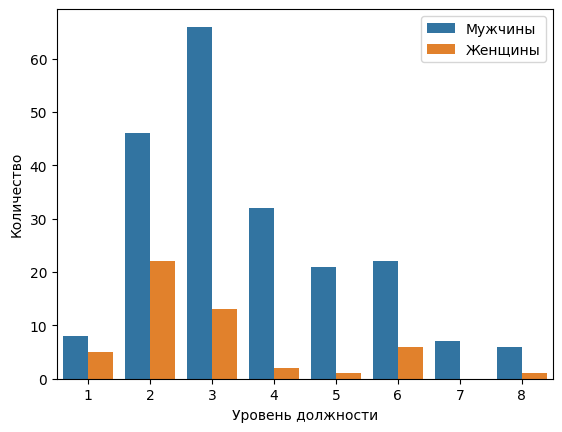

In [95]:
sns.countplot(data=clusterd_df[2], x='Уровень должности', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

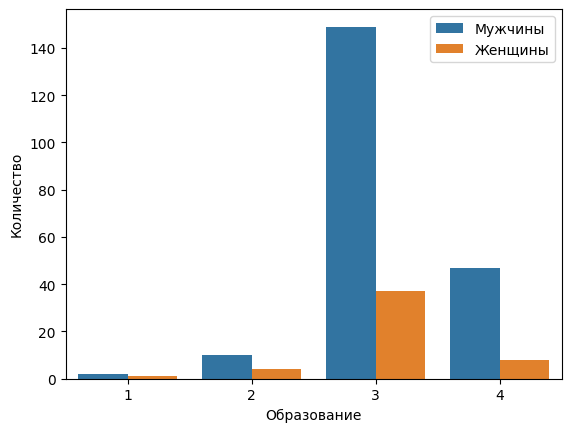

In [97]:
sns.countplot(data=clusterd_df[2], x='Образование', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()